# Apply Long Short-Term Memory (LSTM) networks to trian and predict for ED daily arrivals

Code from Chin-Chieh Wu (Chang Gung University)

In [ ]:
## Load packages
import tensorflow as tf
from tensorflow import keras
import tensorflow.python.keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from keras import backend
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# load the dataset
url = 'https://raw.githubusercontent.com/wujinja-cgu/Time-Series-Analysis/main/time%20series%20data.csv'
dataframe = pd.read_csv(url,index_col=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

<Axes: xlabel='DATE'>

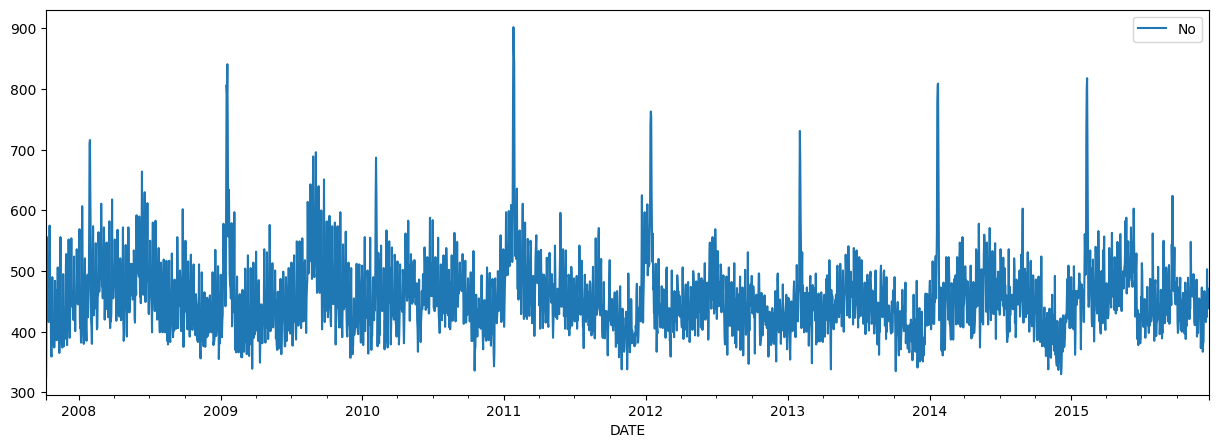

In [ ]:
## plot a time series line plot.
url = 'https://raw.githubusercontent.com/wujinja-cgu/Time-Series-Analysis/main/time%20series%20data.csv'
df = pd.read_csv(url)

## drop the columns we don’t need, then convert “Date” column to datatime data type and set “Date” column to index
##df.drop(['temp', 'humi', 'workday', 'weekend', 'single_day', 'ch_year_low', 'ch_year_high', 'holiday_low', 'holiday_high', 'seasonal', 'temd1', 'temd2', 'temd3'], axis=1, inplace=True)
df['DATE'] = pd.to_datetime(df['DATE'])
ind_df = df.set_index(['DATE'])
ind_df.head()

#df.DATE = pd.to_datetime(df.DATE)
#df = df.set_index("DATE")
#df.head()

ind_df = ind_df.sort_index()
plt.rcParams["figure.figsize"] = (15,5)
ind_df.plot()

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
test_size = 365
train_size = len(dataset) - test_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
#K.get_graph()
#model = tf.keras.Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=300, batch_size=3, verbose=1)

model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=1000, batch_size=30, validation_data=(testX, testY), verbose=1)

Epoch 1/1000
87/87 [==============================] - 3s 10ms/step - loss: 0.0140 - val_loss: 0.0075
Epoch 2/1000
87/87 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 3/1000
87/87 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 4/1000
87/87 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 5/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 6/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 7/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 8/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 9/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 10/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.004

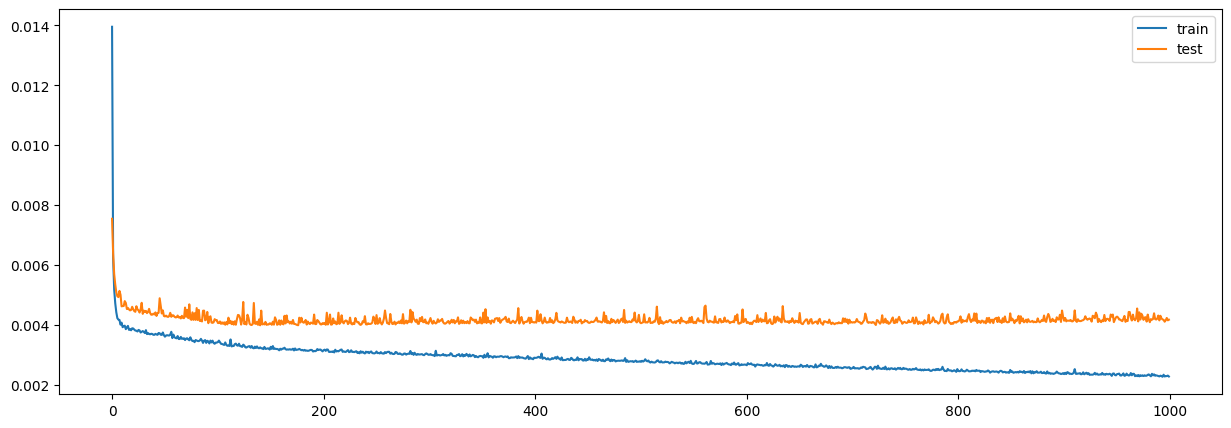

In [ ]:
# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

11/11 [==============================] - 0s 9ms/step


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainrmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainrmse))
testrmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testrmse))

Train RMSE: 27.17
Test RMSE: 37.26


In [ ]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

trainmape = mape(trainY[0], trainPredict[:,0])
print('Train MPAE: %.2f' % (trainmape))
testmape = mape(testY[0], testPredict[:,0])
print('Test MAPE: %.2f' % (testmape))

Train MPAE: 4.65
Test MAPE: 5.85


In [ ]:
# calculate MAE
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)))

trainmae = mae(trainY[0], trainPredict[:,0])
print('Train MAE: %.2f' % (trainmae))
testmae = mae(testY[0], testPredict[:,0])
print('Test MAE: %.2f' % (testmae))

Train MAE: 20.92
Test MAE: 27.40


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

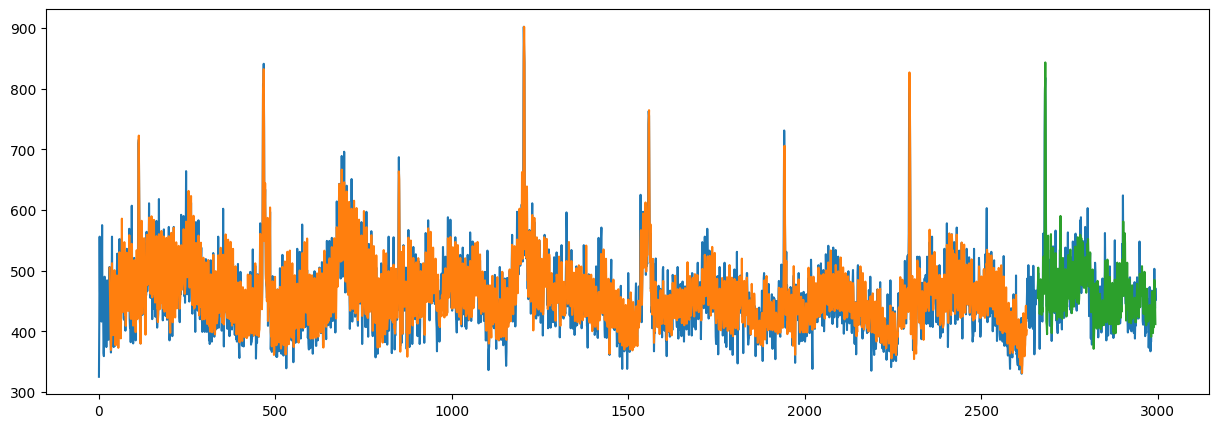

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Text(0.5, 1.0, 'Green stands for true values, Red stands for predictions')

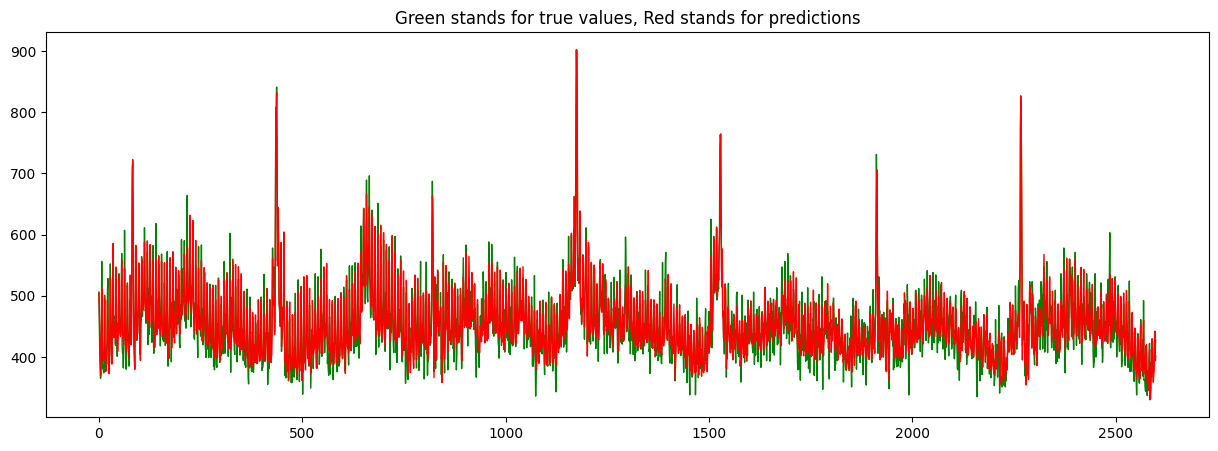

In [ ]:
## plot training set for baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(trainY[0])), trainY[0], linewidth=1, color='g')
plt.plot(np.arange(len(trainPredict[:,0])), trainPredict[:,0], linewidth=1, color='r')
plt.title('Green stands for true values, Red stands for predictions')

Text(0.5, 1.0, 'Green stands for true values, Blue stands for predictions')

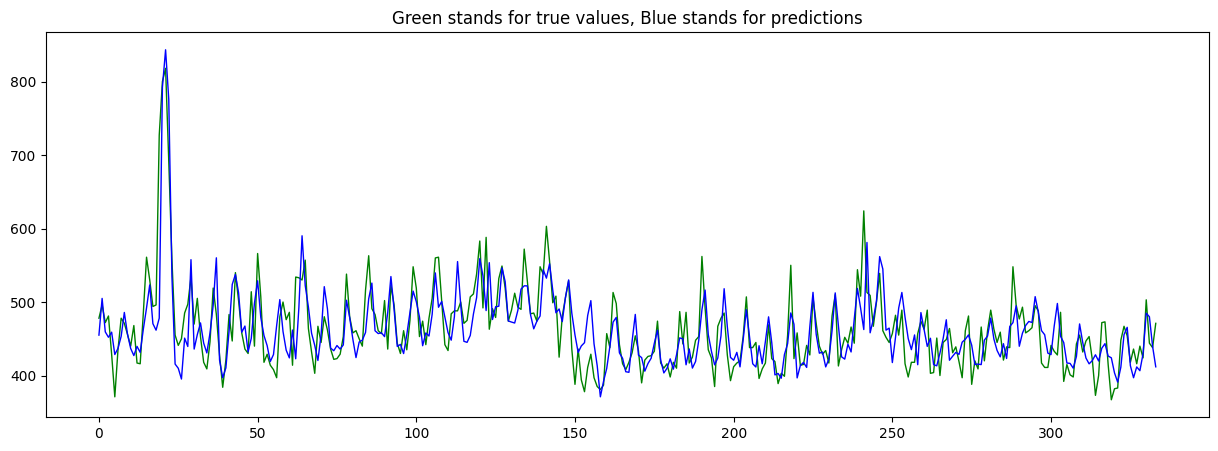

In [ ]:
## plot testing set for baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(testY[0])), testY[0], linewidth=1, color='g')
plt.plot(np.arange(len(testPredict[:,0])), testPredict[:,0], linewidth=1, color='b')
plt.title('Green stands for true values, Blue stands for predictions')